### Notebook Overview

In this notebook, we focus on reducing the size of the original 20M dataset to 1M while ensuring no loss of critical information. This is part of our process to build a recommendation system for E-commerce. The key steps we took include:

- Reduced the 20M dataset to 1M while ensuring no loss of information.
- Sampled users in such a way that their full behavior (all events) is preserved, maintaining complete user profiles.
- Ensured that each sampled user's data is fully represented, unlike randomized sampling.
- Maintained proportional distributions to accurately reflect user interactions and preferences.

These steps help prepare the data for the recommendation system, ensuring accuracy and integrity in the process.

In [2]:
import os
import pandas as pd

# Directory containing the CSV files
directory = "/Users/sivaguganjayachandran/Documents/python programming/Kaggle/e-commerce_recom_system/cosmetics/"

# Initialize an empty list to store individual DataFrames
dfs = []

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        # Read the CSV file
        df = pd.read_csv(os.path.join(directory, filename))
        
        # Extract the month and year from the filename (e.g., '2020-Jan.csv' -> '2020-Jan')
        month_year = filename.replace(".csv", "")
        
        # Add the month column to the DataFrame
        df['month'] = month_year
        
        # Append the DataFrame to the list
        dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(dfs, ignore_index=True)

# Display the first few rows of the combined DataFrame
combined_df.head(5)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,month
0,2020-01-01 00:00:00 UTC,view,5809910,1602943681873052386,NaN,grattol,5.24,595414620,4adb70bb-edbd-4981-b60f-a05bfd32683a,2020-Jan
1,2020-01-01 00:00:09 UTC,view,5812943,1487580012121948301,NaN,kinetics,3.97,595414640,c8c5205d-be43-4f1d-aa56-4828b8151c8a,2020-Jan
2,2020-01-01 00:00:19 UTC,view,5798924,1783999068867920626,NaN,zinger,3.97,595412617,46a5010f-bd69-4fbe-a00d-bb17aa7b46f3,2020-Jan
3,2020-01-01 00:00:24 UTC,view,5793052,1487580005754995573,NaN,NaN,4.92,420652863,546f6af3-a517-4752-a98b-80c4c5860711,2020-Jan
4,2020-01-01 00:00:25 UTC,view,5899926,2115334439910245200,NaN,NaN,3.92,484071203,cff70ddf-529e-4b0c-a4fc-f43a749c0acb,2020-Jan


In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Calculate the number of events for each user in the original DataFrame
user_event_counts = combined_df['user_id'].value_counts()

# Step 2: Define target sample distribution based on user activity level (event count per user)
l1 = combined_df.shape[0]
l2 = 1_000_000

user_count_1 = len(user_event_counts.to_list())
user_count_2 =  user_count_1 / l1 * l2

In [79]:
# Define target number of users per event count level
event_distribution = user_event_counts.value_counts(normalize=True) * user_count_2
users_per_event_count = event_distribution.round().astype(int)

# Find indices where users_per_event_count is 0
zero_event_indices = users_per_event_count[users_per_event_count == 0].index

# Create a new Series to store updated values
updated_users = users_per_event_count.copy()

# Initialize a counter
n = 0

# Iterate through zero-event indices and mark every 20th user
for i in zero_event_indices:
    if n == 20:  # Every 20th user
        updated_users.loc[i] = 1  # Mark as 1
        n = 0  # Reset counter
    else:
        n += 1


users_per_event_count_2 = users_per_event_count
users_per_event_count = updated_users

In [80]:
# Initialize a list to collect sampled data
sampled_data = []

# Step 2: Sample users and their events proportionally for each event count level
for event_count, n_users in users_per_event_count.items():
    # Get users who have exactly this event count
    users_with_count = user_event_counts[user_event_counts == event_count].index

    # Sample the required number of users for this activity level
    sampled_users = users_with_count.to_series().sample(
        n=min(n_users, len(users_with_count)), 
        random_state=42
    )

    # Select all events for the sampled users
    events = combined_df[combined_df['user_id'].isin(sampled_users)]
    sampled_data.append(events)

# Step 3: Combine all sampled data into a single DataFrame
combined_df_sampled = pd.concat(sampled_data).reset_index(drop=True)
print(f"Sampled DataFrame shape: {combined_df_sampled.shape}")  # Display the size of the sampled data

# Sampled DataFrame is ready for analysis

Sampled DataFrame shape: (939864, 10)


<Figure size 1200x600 with 0 Axes>

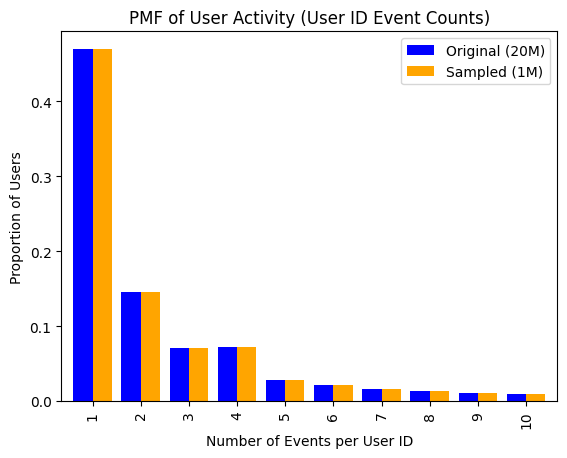

In [82]:
import matplotlib.pyplot as plt

# Calculate PMF for 'user_id' in the original and sampled DataFrames
pmf_original = combined_df['user_id'].value_counts().value_counts(normalize=True).sort_index()
pmf_sampled = combined_df_sampled['user_id'].value_counts().value_counts(normalize=True).sort_index()

# Combine the two PMFs into a single DataFrame for easy plotting
pmf_comparison = pd.DataFrame({'Original (20M)': pmf_original[:10], 'Sampled (1M)': pmf_sampled[:10]}).fillna(0)

# Plot the PMFs
plt.figure(figsize=(12, 6))
pmf_comparison.plot(kind='bar', width=0.8, color=['blue', 'orange'])
plt.title("PMF of User Activity (User ID Event Counts)")
plt.xlabel("Number of Events per User ID")
plt.ylabel("Proportion of Users")
plt.legend()
plt.show()


<Figure size 1200x600 with 0 Axes>

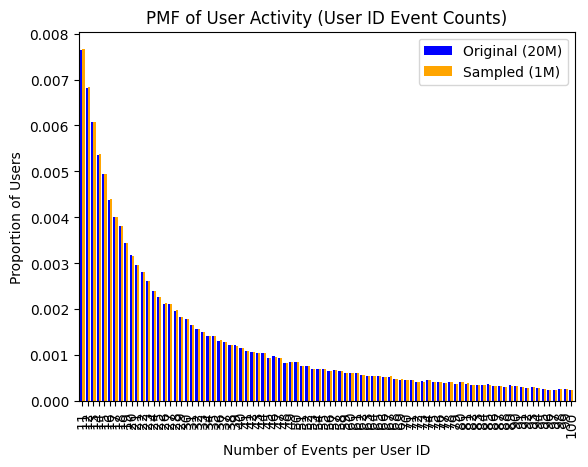

In [83]:
# Combine the two PMFs into a single DataFrame for easy plotting
pmf_comparison = pd.DataFrame({'Original (20M)': pmf_original[10:100], 'Sampled (1M)': pmf_sampled[10:100]}).fillna(0)

# Plot the PMFs
plt.figure(figsize=(12, 6))
pmf_comparison.plot(kind='bar', width=0.8, color=['blue', 'orange'])
plt.title("PMF of User Activity (User ID Event Counts)")
plt.xlabel("Number of Events per User ID")
plt.ylabel("Proportion of Users")
plt.legend()
plt.show()


<Figure size 1200x600 with 0 Axes>

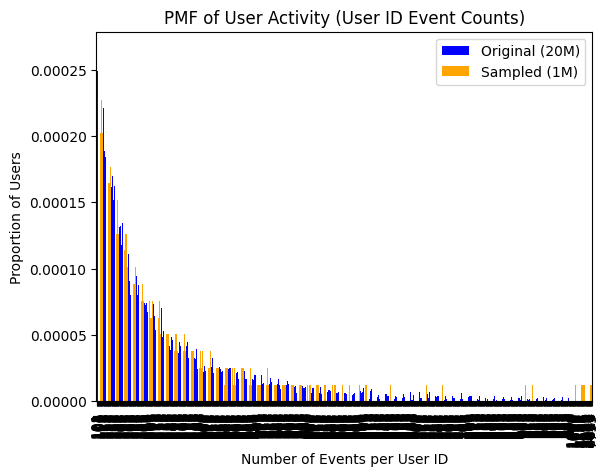

In [84]:
# Combine the two PMFs into a single DataFrame for easy plotting
pmf_comparison = pd.DataFrame({'Original (20M)': pmf_original[100:1000], 'Sampled (1M)': pmf_sampled[100:1000]}).fillna(0)

# Plot the PMFs
plt.figure(figsize=(12, 6))
pmf_comparison.plot(kind='bar', width=0.8, color=['blue', 'orange'])
plt.title("PMF of User Activity (User ID Event Counts)")
plt.xlabel("Number of Events per User ID")
plt.ylabel("Proportion of Users")
plt.legend()
plt.show()


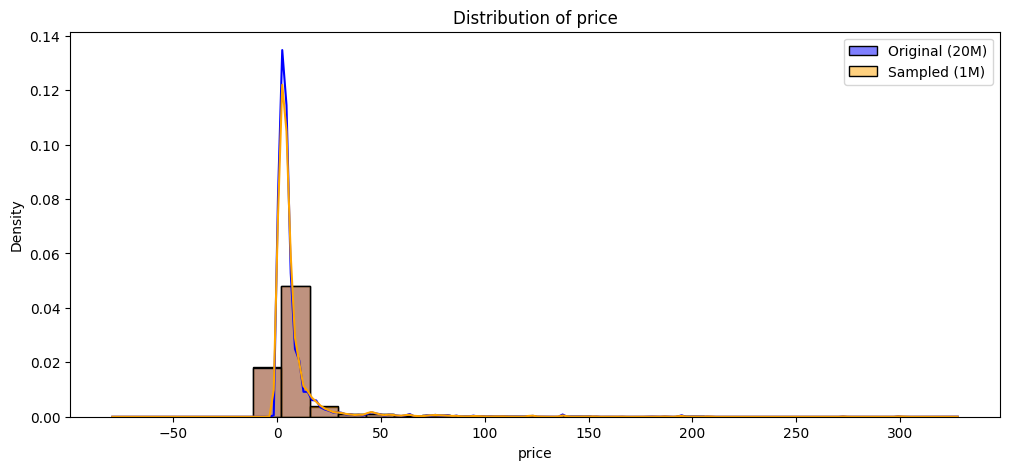

<Figure size 1200x500 with 0 Axes>

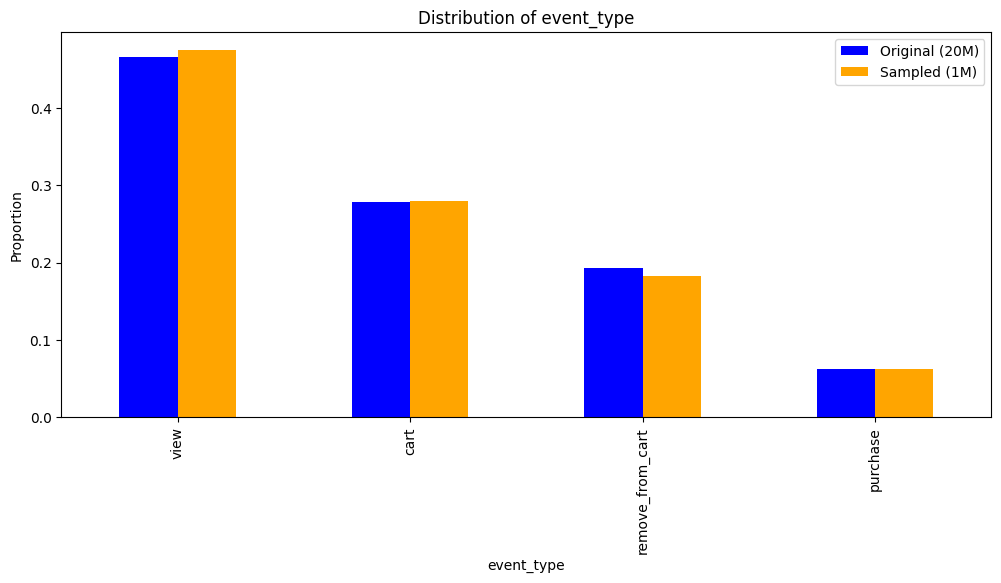

<Figure size 1200x500 with 0 Axes>

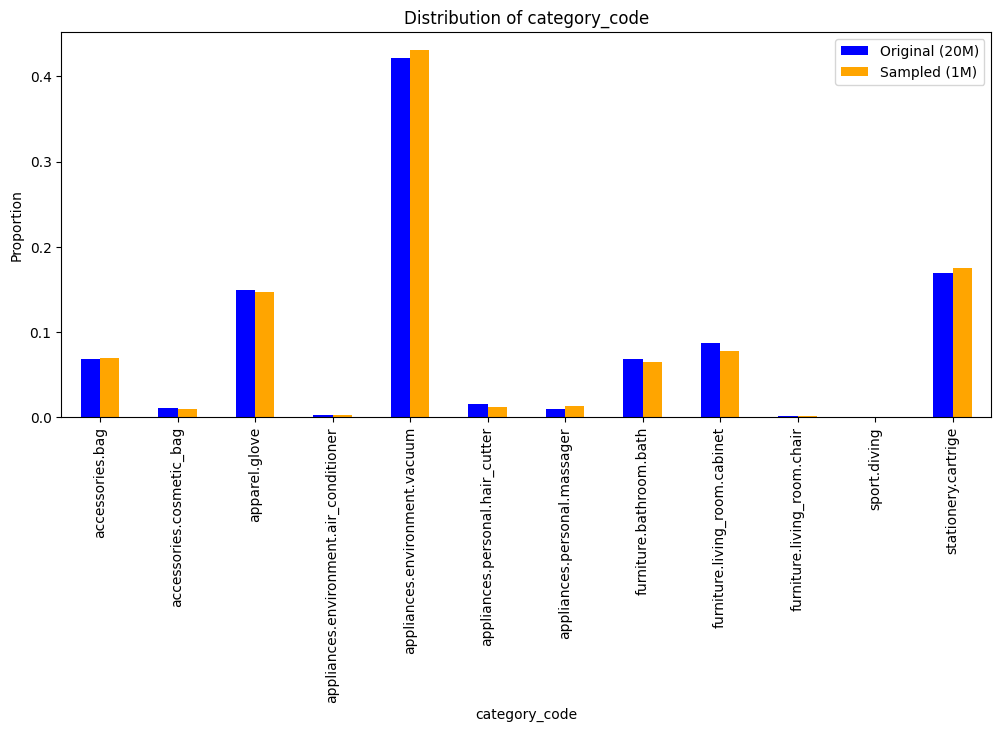

<Figure size 1200x500 with 0 Axes>

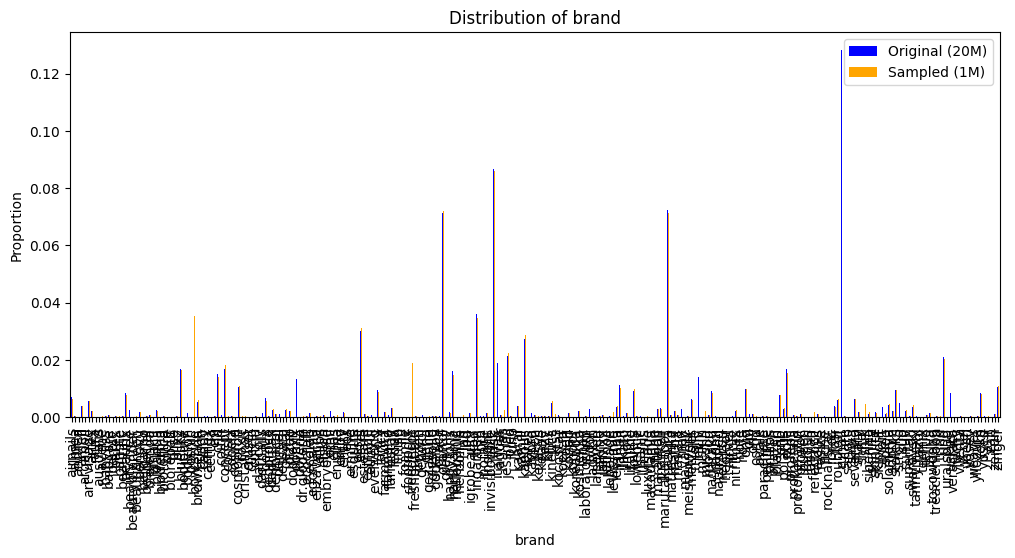

<Figure size 1200x500 with 0 Axes>

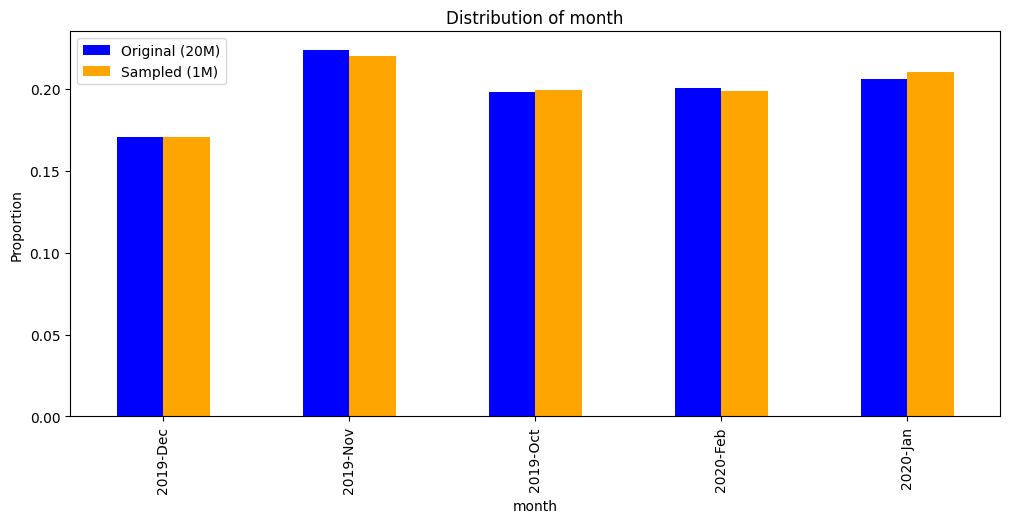

<Figure size 1200x500 with 0 Axes>

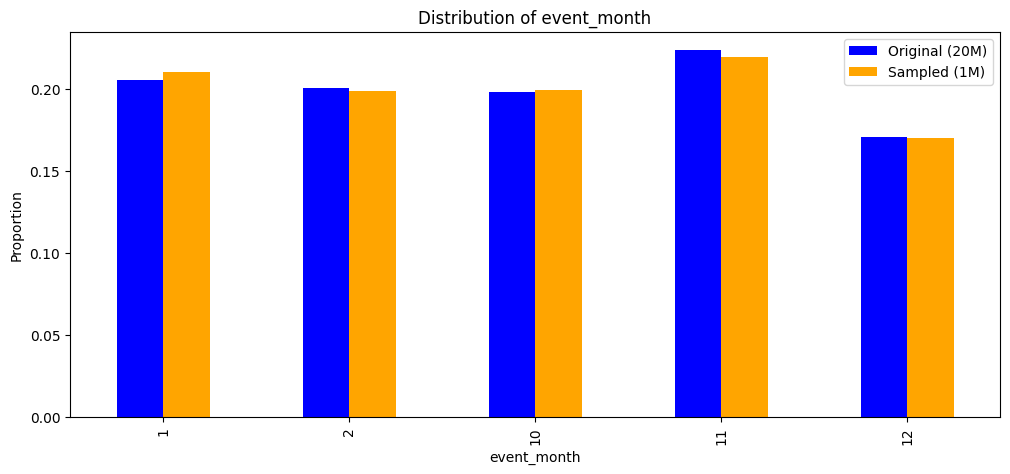

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume combined_df is the original DataFrame and combined_df_sampled is the sampled DataFrame

# Function to plot and compare distributions for numerical columns
def compare_numerical_distributions(df_original, df_sampled, column_name):
    plt.figure(figsize=(12, 5))
    
    sns.histplot(df_original[column_name], color='blue', kde=True, label='Original (20M)', bins=30, stat='density')
    sns.histplot(df_sampled[column_name], color='orange', kde=True, label='Sampled (1M)', bins=30, stat='density')
    
    plt.title(f"Distribution of {column_name}")
    plt.legend()
    plt.show()

# Function to plot and compare distributions for categorical columns
def compare_categorical_distributions(df_original, df_sampled, column_name):
    plt.figure(figsize=(12, 5))
    
    # Plot the normalized value counts for both original and sampled data
    original_counts = df_original[column_name].value_counts(normalize=True)
    sampled_counts = df_sampled[column_name].value_counts(normalize=True)
    
    # Merge the distributions into a DataFrame for easier plotting
    comparison_df = pd.DataFrame({'Original (20M)': original_counts, 'Sampled (1M)': sampled_counts}).fillna(0)
    comparison_df.plot(kind='bar', figsize=(12, 5), color=['blue', 'orange'])
    
    plt.title(f"Distribution of {column_name}")
    plt.ylabel("Proportion")
    plt.show()

# List of columns to compare
numerical_columns = ['price']  # You can add more numerical columns if available
categorical_columns = ['event_type', 'category_code', 'brand', 'month']

# Compare numerical columns
for col in numerical_columns:
    compare_numerical_distributions(combined_df, combined_df_sampled, col)

# Compare categorical columns
for col in categorical_columns:
    compare_categorical_distributions(combined_df, combined_df_sampled, col)

# Additional comparison for date/time column, e.g., by month
combined_df['event_month'] = pd.to_datetime(combined_df['event_time']).dt.month
combined_df_sampled['event_month'] = pd.to_datetime(combined_df_sampled['event_time']).dt.month

compare_categorical_distributions(combined_df, combined_df_sampled, 'event_month')


Hence, based on the above plots, we can infer that the sampled data distribution is in the same PMF ratios as the original DataFrame.
	
    •	Reduced the 20M dataset to 1M without losing any information.
	•	Sampled users while preserving their full behavior (all events) to maintain complete profiles.
	•	Unlike randomized sampling, this approach ensures that each sampled user’s data is fully represented.
	•	Maintained proportional distributions to accurately reflect user interactions and preferences for E-commerce recommendations.

In [88]:
directory2 = "/Users/sivaguganjayachandran/Documents/python programming/Kaggle/e-commerce_recom_system/"
combined_df_sampled.to_csv(directory2 + 'sampled_df.csv')